In [923]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math

In [924]:
df_bilt = pd.read_csv('/Users/georgepetropoulos/Desktop/de_bilt_weather.csv')

#shift days so that the first day starts from zero
df_bilt['days'] = df_bilt['days'] - df_bilt['days'].min()

variables = ['cloud_cover', 'wind_speed', 'wind_gust', 'humidity',
             'pressure', 'global_radiation', 'precipitation', 'sunshine', 
             'temp_mean', 'temp_min', 'temp_max'] 

n_var = len(variables) 

In [925]:
#Training on year of data, testing on 10 days
train_range = 365
test_range = 10

In [926]:
#Extracting data with shape (n_var, train_range+test_range)
data = []
for variable_name in variables:
    data.append(df_bilt[variable_name][:train_range + test_range])
data = np.vstack(data)

In [927]:
#Spliting training and test sets
train_data = data[:, :train_range]   
test_data = data[:, train_range:]

In [928]:
#Cost function for the optimizer
def var_initial_norm(params, data, means, n_var):
    c = params[:n_var]
    matrix = params[n_var:].reshape(n_var, n_var)
    prediction = c[:, None] + matrix @ data[:, :-1]
    residuals = data[:, 1:] - prediction
    return np.linalg.norm(residuals / means[:, None])

In [929]:
#Initialize c and M to zero
params = np.zeros(n_var + n_var**2)
means = np.mean(train_data, axis=1)

#Scipy's optimizer fits model parameters by minimizing cost function
result = scipy.optimize.minimize(var_initial_norm, params, method='Powell', args=(train_data, means, n_var))

#Represents the fitted intercepts and coefficient matrix
c_var = result.x[:n_var]
M_var = result.x[n_var:].reshape(n_var, n_var)

#Calculate residuals of fitted model
residuals = train_data[:, 1:] - (c_var[:, None] + M_var @ train_data[:, :-1])

#Generating uncertainty in predictions
std_var = np.std(residuals, axis=1)

In [930]:
#Produces predictions for next day given today, fits model plus normally distributed noise for uncertainty.
def weather_var(x, c, M, std):
    return c + M @ x + np.random.normal(0, std)

#Time indices for training and testing
t_train_data = np.arange(train_range)
t_test_data = np.arange(train_range, train_range + test_range)

#Number of simulation runs to capture uncertainty
prediction_list = []
n_predictions = 1000 

for j in range(n_predictions):
    #First test day is initial condition
    prediction = [test_data[:, 0]]
    #Predict forward for remaining test days
    for _ in t_test_data[1:]:
        prediction.append(weather_var(prediction[-1], c_var, M_var, std_var))
    prediction = np.array(prediction).T
    prediction_list.append(prediction)

#List of predictions converting to array with shape (n_predictions, n_var, test_range)
prediction_matrix = np.array(prediction_list)

In [931]:
#period analyzed is yearly
period = train_range

#Stores R^2 yearly seasonality of each variable
seasonality_results = []

for var in variables:
    variable_data = df_bilt[var].values
    
    #Compute how many full seasonal cycles fit into the data
    full_cycles = len(variable_data) // period
    
    #Trim data to full cycles only, so for 3654 to 3650
    trim_len = full_cycles * period
    trimmed_data = variable_data[:trim_len]
    
    #Reshaping trimmed data so that each row represents one full cycle, shape = (10, 365)
    data_matrix = trimmed_data.reshape(full_cycles, period)
    
    #Find average of seasonal fluctuations (average over all cycles for each day in the cycle)
    seasonalality = np.mean(data_matrix, axis = 0) 
    
    #Reconstruct a seasonal-only signal by repeating the seasonalality measure as many times as full cycles
    seasonal_signal = np.tile(seasonalality, full_cycles)
    
    #How well does seasonal only signal capture the true data 
    residuals = trimmed_data - seasonal_signal
    SS_res = np.sum(residuals**2)
    SS_tot = np.sum((trimmed_data - np.mean(trimmed_data))**2)
    #fraction of the variability explained by the seasonal pattern
    R_squared = 1 - (SS_res / SS_tot)
    
    seasonality_results.append((var, R_squared))

#Sort by R^2 in descending order 
seasonality_results.sort(key = lambda x: x[1], reverse = True)
print("Variables ranked by seasonality strength (R^2):")
for var, r2 in seasonality_results:
    print(f"{var}: {r2}")

Variables ranked by seasonality strength (R^2):
temp_max: 0.7654874946970054
temp_mean: 0.7574366466441151
global_radiation: 0.7214944431344943
temp_min: 0.645212620396965
humidity: 0.3736146958374804
sunshine: 0.30432771661073643
wind_speed: 0.17013694221707387
cloud_cover: 0.14250096177190008
wind_gust: 0.11003862019307753
pressure: 0.10219603203301231
precipitation: 0.0904754980150474


In [932]:
#Based on seasonality results
seasonal_vars = ['temp_max', 'temp_mean', 'global_radiation', 'temp_min', 'sunshine']
non_seasonal_vars = ['precipitation', 'cloud_cover', 'wind_gust', 'pressure', 'humidity', 'wind_speed']

#Storing indices from data of respective groups
seasonal_indices = [variables.index(var) for var in seasonal_vars]
non_seasonal_indices = [variables.index(var) for var in non_seasonal_vars]

#Given var estimated c_var and M_var of a previous days x vector return todays prediciton without noise
def deterministic_forecast(x, c, M):
    return c + M @ x

#Stores the forecasts for the entire test range starting with the yesterdays actual data as the initial
det_predictions = [test_data[:, 0]]

#For each subsequent test day, forecast using the previous days predicted values
for t in t_test_data[1:]:
    det_predictions.append(deterministic_forecast(det_predictions[-1], c_var, M_var))


#Convert from list of arrays to single array 
det_predictions = np.array(det_predictions).T

#Forecast error 
errors = test_data - det_predictions

#RMSE calc for each variable across the full test period
rmse = np.sqrt(np.mean(errors**2, axis = 1))

#Extract RMSEs for the seasonal and non-seasonal groups separately
seasonal_rmse = rmse[seasonal_indices]
non_seasonal_rmse = rmse[non_seasonal_indices]

def welch_ttest(x, y):

    #sample lengths, means, variances
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x, ddof = 1), np.var(y, ddof = 1)

    #Find Welchs t-stat
    t_stat = (mean_x - mean_y) / math.sqrt(var_x/nx + var_y/ny)

    #Approximate p-value using the cdf of a standard normal distribution
    def normal_cdf(z):
        return 0.5 * (1.0 + math.erf(z / math.sqrt(2)))

    #Two-sided p-value
    p_value = 2.0 * (1.0 - normal_cdf(abs(t_stat)))

    return t_stat, p_value

t_stat, p_value = welch_ttest(seasonal_rmse, non_seasonal_rmse)

print("Seasonal RMSE:", seasonal_rmse)
print("Non-Seasonal RMSE:", non_seasonal_rmse)
print("T-test statistic:", t_stat)
print("P-value:", p_value)

Seasonal RMSE: [3.6901002  3.61447743 0.1163022  3.94038575 1.68787526]
Non-Seasonal RMSE: [0.57851531 1.2595427  3.54890092 0.01483592 0.03920313 1.19162911]
T-test statistic: 1.643802280937631
P-value: 0.10021705006818804


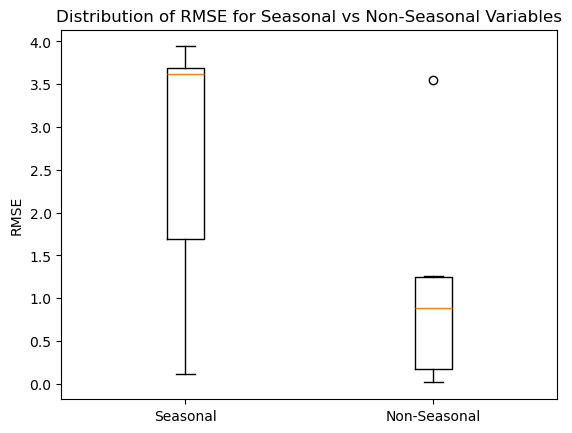

In [933]:
data_to_plot = [seasonal_rmse, non_seasonal_rmse]

fig, ax = plt.subplots()
ax.boxplot(data_to_plot, tick_labels=['Seasonal', 'Non-Seasonal'])
ax.set_ylabel('RMSE')
ax.set_title('Distribution of RMSE for Seasonal vs Non-Seasonal Variables')
plt.show()